<a href="https://colab.research.google.com/github/s1c5000/Books/blob/main/handson/%EB%B6%84%EB%A5%98_%EC%A0%95%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 오차행렬

분류기 성능평가시 사용       
A클래스의 샘플이 B로 분류된 횟수를 세는 것

In [ ]:
####필요모듈 다운로드 
# 파이썬 ≥3.5 필수
import sys

# 사이킷런 ≥0.20 필수
import sklearn

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
# mnist 예제
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#### 불균형한 데이터를 정확도로 성능평가를 했을때

In [ ]:
# 이진분류기를 만들기위해 5인 것들만 뽑아 레이블을 만든다
# 5 or 5아님 으로만 분류됨
# 전부 5아님으로 해도 90프로 정확도가 나온다

y_train_5 = (y_train == 5) # 5인 것들만 저장
y_test_5 = (y_test == 5)

In [ ]:
#확률적경사하강법(SGD)로 분류를 해본다.
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# 교차검증을 사용해 모델을 평가해보겠다.
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

확률적경사하강법(SGD)으로 교차검증 해보면 높은 정확도를 얻는다      
하지만 이는 분균형한 데이터셋이여서 그렇다 '5아님' 으로 예측을 해도 정확도가 90%이다.     
-->> 올바르지 않은 성능평가

### 오차행렬 실습

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
print(y_train_pred[:10])

[ True False False False False False False False False False]


cross_val_score() 는 교차검증 후 평가점수를 반환하지만 cross_val_predict()는 각 테스트 폴드에서 얻은 예측을 반환한다      

In [ ]:
# 오차행렬 사용
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차행렬의 행은 실제 클래스를 나타낸다    
열은 예측한 클래스를 나타낸다     

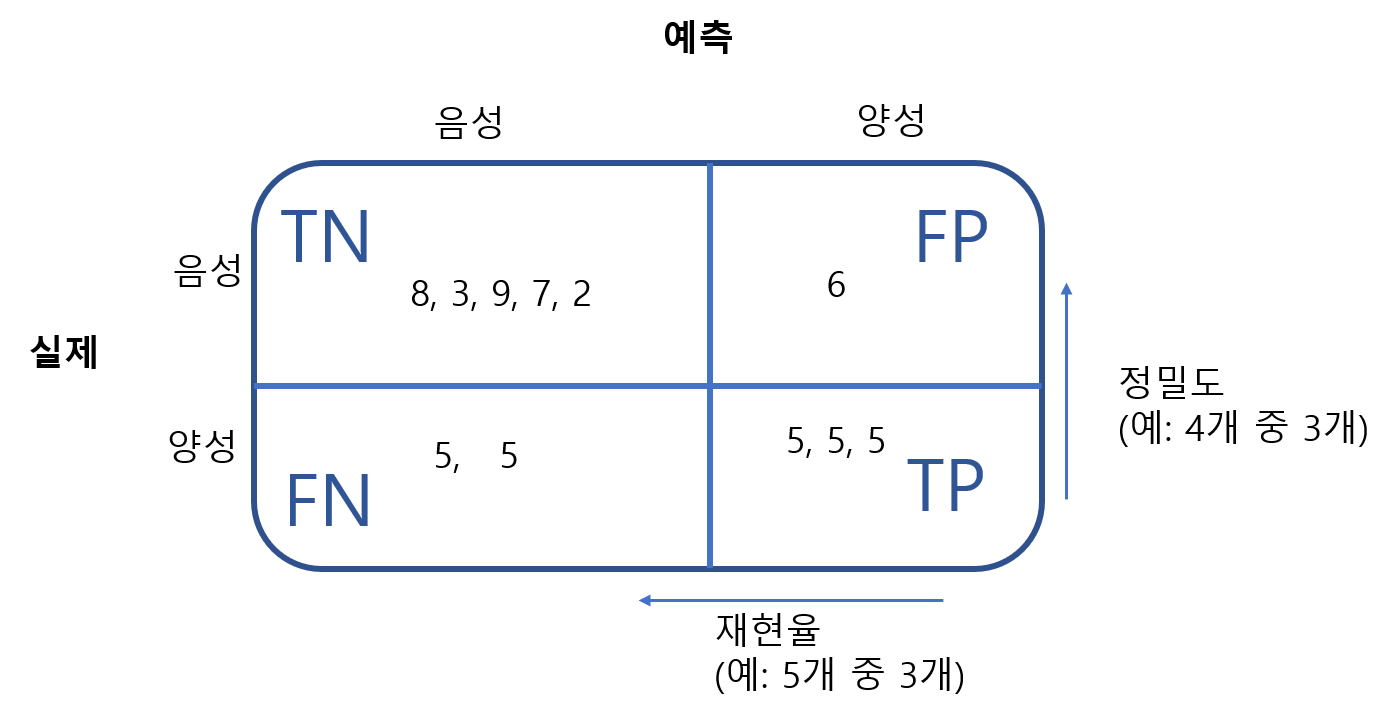

정밀도(Precision) : TP/ TP+FP      

>양성으로 예측한 값중 실제 정답값

재현률(Recall, 민감도, TPR) : TP/ TP+FN     


> 실제 정답값중 예측으로 정답을 맞춘값



In [ ]:
#정밀도와 재현률 포함하여 분류기의 지표를 계산하는 함수를 제공한다
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # 정밀도

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred) # 재현률

0.6511713705958311

F1 점수 : 정밀도와 재현률을 이용해서 하나의 점수로 만든다

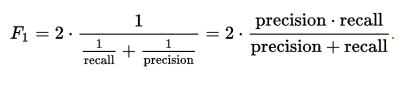

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기는 F1점수가 높다.     
항상 바람직한건 아니고 상황에 따라 다르다

정밀도/재현률 트레이드오프  
결정 임계값에 따라 달라진다.  
임계값을 올리면 정밀도가 올라가고 재현률이 낮아진다  
임계값을 내리면 정밀도가 낮아지고 재현률이 올라간다  

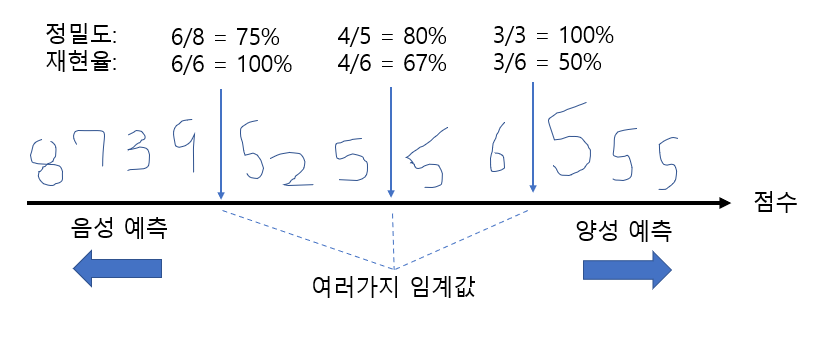

결정 임계값에 대한 정밀도와 재현율

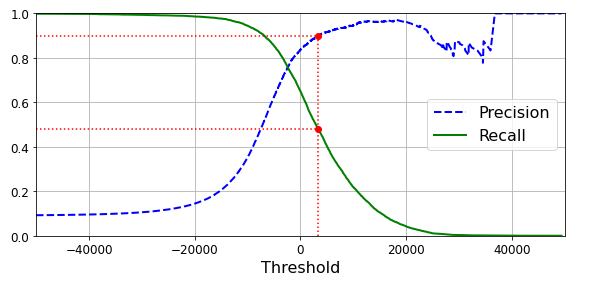

## ROC곡선

거짓양성비율(FPR)에 대한 진짜양성비율(TPR,재현률)

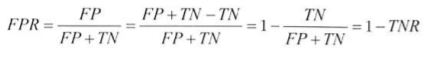

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
# cross_val_predict()를 사용하지만 예측결과가 아니라 결정점수를 반환받는다.

In [ ]:
print(y_scores[:10])

[  1200.93051237 -26883.79202424 -33072.03475406 -15919.5480689
 -20003.53970191 -16652.87731528 -14276.86944263 -23328.13728948
  -5172.79611432 -13873.5025381 ]


In [ ]:
# roc곡선 아래의 면적
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

모든 가능한 임계값에서 진짜 양성비율에 대한 거짓 양성 비율을 나타낸 ROC곡선,   
붉은 점이 선택한 비율의 지점이다

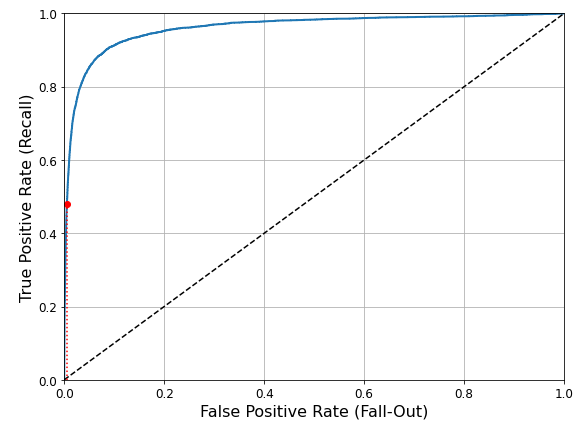

점선의 경우 완전랜덤분류기이고  점선에서 멀리떨어질 수록 좋다

# 다중분류기

In [ ]:
# OvR, OvO 이진분류기 여러개로 다중클래스를 분류
# 다중분류작업에 이진분류 알고리즘을 선택하면 사이킷런이 자동으로 OvR 또는 OvO를 실행
from sklearn.svm import SVC

some_digit = X[0]
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
# 내부에서 10개의 이진분류기를 훈련시키고 각각의 결정점수를 얻어 높은 클래스를 선택
# decision_fouction() 메서드로 샘플당 10개의 점수를 반환한다.
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
# svc기반으로 OvR전략을 사용하는 다중 분류기
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(X_test)

array([7, 2, 1, ..., 8, 5, 6], dtype=uint8)

In [ ]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

교차검증을 통해 다중분류를 해보았다     
스케일링을 해주면 더 결과가 좋다

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv= 3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## 에러분석

모델의 오차행렬을 통해 에러를 분석 할 수있다.

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

이미지로 표현해 보겠다

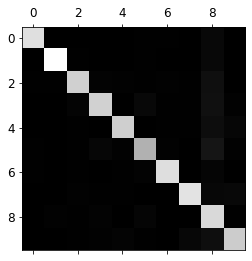

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

잘 예측될수록 밝은 색으로 나온다.     
5는 좀 어두운데 다른 수 만큼 잘 분류하지 못한다는 뜻이다.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True) #세로축으로 더한다.
norm_conf_mx = conf_mx / row_sums # 각 수마다 예측된 값의 비율을 나타낸다.

In [ ]:
print(row_sums)
print(norm_conf_mx)

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]
[[9.41583657e-01 0.00000000e+00 3.71433395e-03 8.44166807e-04
  1.35066689e-03 7.25983454e-03 6.07800101e-03 1.01300017e-03
  3.79875063e-02 1.68833361e-04]
 [0.00000000e+00 9.49273213e-01 5.48798576e-03 3.55977455e-03
  5.93295758e-04 6.52625334e-03 5.93295758e-04 1.03826758e-03
  3.14446752e-02 1.48323939e-03]
 [4.53172205e-03 4.53172205e-03 8.76132931e-01 1.54414233e-02
  1.22524337e-02 4.53172205e-03 1.12453844e-02 6.04229607e-03
  6.34441088e-02 1.84625713e-03]
 [3.58832164e-03 2.77279400e-03 1.90833469e-02 8.52552602e-01
  3.26211059e-04 3.31104224e-02 4.40384929e-03 6.52422117e-03
  6.57315283e-02 1.19067036e-02]
 [2.05409106e-03 2.39643958e-03 7.01814447e-03 1.54056830e-03
  8.87024991e-01 2.05409106e-03 5.81992468e-03 4.62170490e-03
  5.93974666e-02 2.80725779e-02]
 [4.98063088e-03 2.76701716e-03 5.53403431e-03 3.09905921e-02
  9.77679395e-03 8.19774949e-01 1.38350858e-02 2.58254935e-03
  9.869027

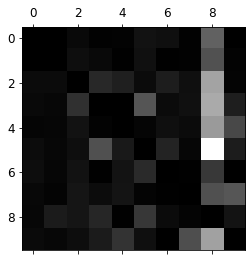

In [ ]:

np.fill_diagonal(norm_conf_mx, 0) # 대각선을 0으로 채운다.
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

행은 실제클레스, 열은 예측값이다. 8열이 상당히 밝은건 많은 이미지가 8로 잘못 분류되었음을 의미한다. 3과 5또한 많이 혼동된다.